## Final Project Submission

* Student name: Jim Petoskey
* Student pace: Self-paced
* Scheduled project review date/time: Friday Feb 25, 2022 at 10:30 am 
* Instructor name: Abhineet Kulkarni
* Blog post URL: 
https://dev.to/jpetoskey/reap-return-on-home-remodel-35cm-temp-slug-7110869?preview=cfd57ff75f52f8f97d40012dae0383603926d95f772a119bd16af2d7e9d72c0486b48924df00a9b5660517361d1743d09317533548b17445419b7136


# Return on Renovation
* For homeowners looking to invest in their property, what renovations offer the best return?
    * This project explores a variety of home price predictors to recommend which renovations are likely to increase sale price.

# Exploring Data

In [77]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import random

%matplotlib inline

In [78]:
house_df = pd.read_csv('data/kc_house_data.csv')
#column_names = pd.read_csv('data/column_names.md')

## What's in kc_house_data?

In [79]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [80]:
house_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


# First Model - Baseline

## Use 3-4 predictors from numerical data in the King County Housing data set to create baseline model.

In [81]:
# set numerical data in new data frame
numericals = house_df[['bedrooms', 
                       'bathrooms', 
                       'sqft_living', 
                       'sqft_lot', 
                       'floors',
                       'sqft_above',
                       'yr_built',
                       'yr_renovated',
                       'zipcode', 
                       'sqft_living15', 
                       'sqft_lot15']]

# set target column
y = house_df['price']

numericals.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,1180,1955,0.0,98178,1340,5650
1,3,2.25,2570,7242,2.0,2170,1951,1991.0,98125,1690,7639
2,2,1.00,770,10000,1.0,770,1933,NaN,98028,2720,8062
3,4,3.00,1960,5000,1.0,1050,1965,0.0,98136,1360,5000
4,3,2.00,1680,8080,1.0,1680,1987,0.0,98074,1800,7503


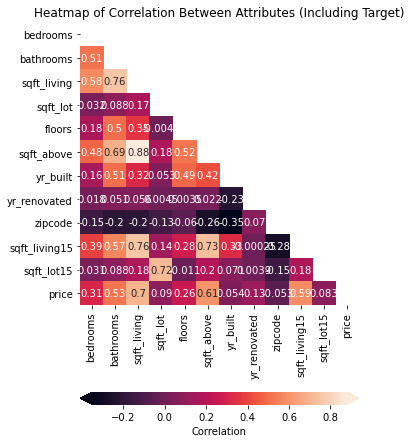

In [82]:
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = pd.concat([numericals, y], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(5, 8))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

### Build a model with the top three numerical values, then I will examine and likely add-in categoricals after one-hot-encoding the non-numericals.

* The top three predictors are: sqft_living, (dropping sqft_above and sqft_living15 - see explanation below), bathrooms, and bedrooms.

* I will drop two of the three sqft_living, sqft_living15, and sqft_above because they  exhibit strong correlation to each other and likely strong multicollinearity.  Considering sqft_living has a stronger correlation to price, which is our target, I will drop sqft_living15 and sqft_above.

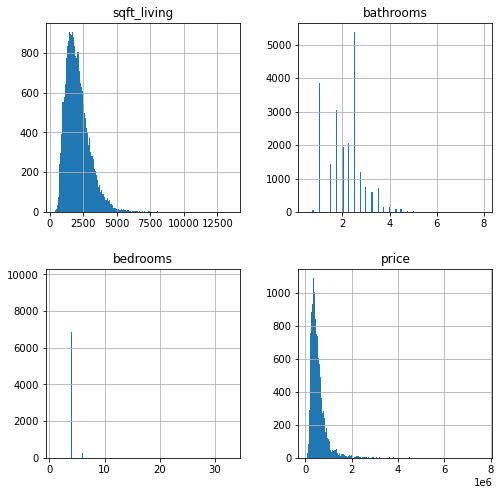

In [345]:
# Set top three numerical values
t3_numericals = house_df[['sqft_living', 'bathrooms', 'bedrooms', 'price']]

# Look at histograms for patterns
t3_numericals.hist(figsize = [8, 8], bins='auto');

### Log Tranformations
* Remove outliers later - especially in the bedrooms and sqft_living categories.

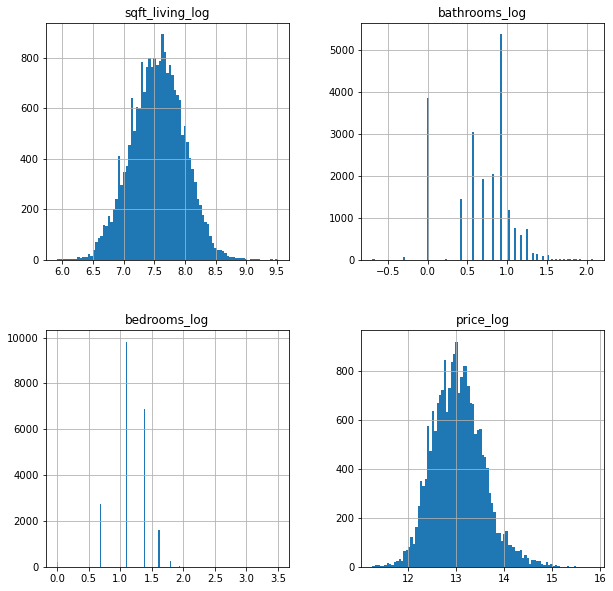

In [346]:
# Perform log transformations for t3_numericals 

log_names = [f'{column}_log' for column in t3_numericals.columns]

house_log = np.log(t3_numericals)
house_log.columns = log_names
house_log.hist(figsize=(10, 10), bins='auto')
fig.tight_layout();

### Normalization
* Skewness from outliers reduced with the log function performed.

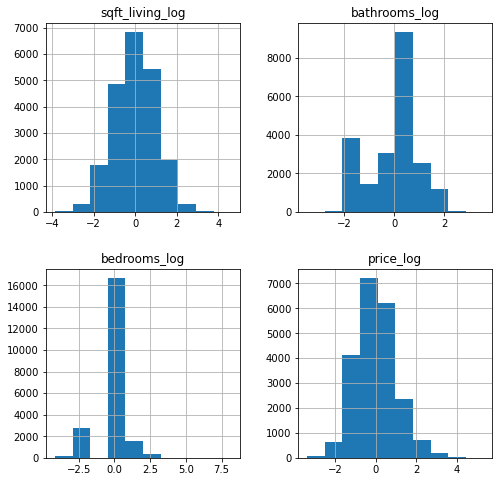

In [347]:
# Standardize the log features

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

features_final = house_log.apply(normalize)

features_final.hist(figsize  = [8, 8]);

In [86]:
features_final.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log
0,-1.125556,-1.726509,-0.279718,-1.401998
1,0.709446,0.339653,-0.279718,0.279938
2,-2.131893,-1.726509,-1.711611,-1.799430
3,0.070674,1.072635,0.736226,0.499698
4,-0.292725,0.039555,-0.279718,0.178434


In [87]:
# Model Summary
X = features_final.drop(['price_log'], axis=1)
y = features_final['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     6414.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:28:37   Log-Likelihood:                -23764.
No. Observations:               21597   AIC:                         4.754e+04
Df Residuals:                   21593   BIC:                         4.757e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.343e-15      0.005   2.71e-13      1.000      -0.010       0.010
sqft_living_log     0.7572      0.008     89.141      0.000       0.741       0.774
bathrooms_log       0.0325      0.008      4.244      0.000       0.017       0.047
bedrooms_log       -0.1652      0.007    -25.342      0.000      -0.178      -0.152
==============================================================================
Omnibus:                      104.465   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.162
Skew:                           0.139   Prob(JB):                     2.93e-22
Kurtosis:                       2.820   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [532]:
first_model = features_final

## Baseline Model - moderate R-squared value, good p-values, condition number, and identical Adjusted R-squared value.

* The R-squared value is not very high, but hopefully it will increase after I modify some of the data and include categorical variables.  This seems like a solid baseline model to work from as the p-values for the predictors fall far below the threshold of 5%, the condition number is low, indicating low multicollinearity, the standard errors are all far lower than the values of the coefficients, and the adjusted R-squared value is identical to the R-squared value, indicating we have a very low bias.

* As I alter the model, likely increasing complexity in order to increase the predictive capacity of the model, the adjusted R-squared value will probably not maintain equality or near-equality with the R-squared value.

## Train, Test, Split - First Model

In [533]:
X = first_model.drop('price_log', axis=1)
y = first_model['price_log']

In [555]:
# Split the data into training and test sets. Changed split size based on 
# the evaluation of train-test-split size below.  40% test size had a lower
# average variance than 25% or 30%.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [556]:
linreg = LinearRegression()

In [557]:
# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [558]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [559]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [560]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.5326927967530528
Test Mean Squared Error: 0.5231689876637725


## Evaluate the effect of train-test split size.

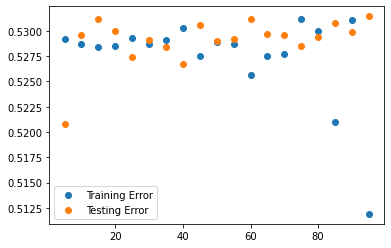

In [561]:
random.seed(900)

train_err = []
test_err = []
t_sizes = range(5,100,5)
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

# Preprocess Categorical Variables

Variable Descriptions for Categorical Variables.

In [232]:
# create categorical variable data set
categoricals = house_df[['waterfront', 
                         'view', 
                         'condition', 
                         'grade'
]]

preprocessed = categoricals

## Dropped columns - id, date, sqft_basement.
* I dropped these columns because sqft_living is already incorporated into the model and other sqft categories had strong correlation with each other and would likely cause issues due to multicollinarity.

In [233]:
categoricals.describe

<bound method NDFrame.describe of       waterfront  view  condition          grade
0            NaN  NONE    Average      7 Average
1             NO  NONE    Average      7 Average
2             NO  NONE    Average  6 Low Average
3             NO  NONE  Very Good      7 Average
4             NO  NONE    Average         8 Good
...          ...   ...        ...            ...
21592         NO  NONE    Average         8 Good
21593         NO  NONE    Average         8 Good
21594         NO  NONE    Average      7 Average
21595        NaN  NONE    Average         8 Good
21596         NO  NONE    Average      7 Average

[21597 rows x 4 columns]>

## Plot categoricals to look for correlation to price.

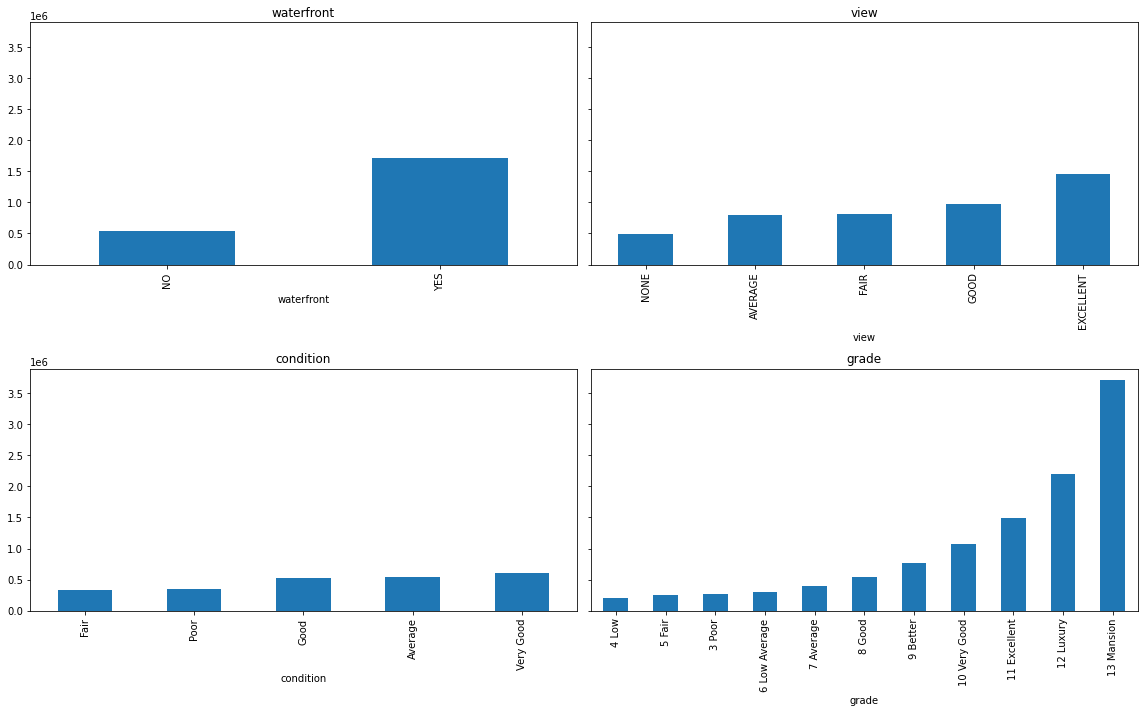

In [234]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharey=True)

for col, ax in zip(categoricals, axes.flatten()):
    (house_df.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

### Promising Predictors - seem to correlate well with price from a visual inspection.

## Investigate nan values

In [235]:
categoricals.isnull().sum()

waterfront    2376
view            63
condition        0
grade            0
dtype: int64

In [236]:
# checking for nan values from categoricals['view']
categoricals['view'].value_counts(dropna=False)

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
NaN             63
Name: view, dtype: int64

In [237]:
# drops the whole row - removing some important data from other categories
# categoricals.dropna(subset=['waterfront'], inplace=True)

In [238]:
categoricals.isnull().sum()

waterfront    2376
view            63
condition        0
grade            0
dtype: int64

### Investigate nan values - waterfront

In [239]:
categoricals['waterfront'].value_counts(dropna=False)

NO     19075
NaN     2376
YES      146
Name: waterfront, dtype: int64

#### Create Missing Values Column - waterfront
* Saves nan information in the case that it is valuable later.

In [240]:
# (1) Identify data to be transformed
# We only want missing indicators for LotFrontage
waterfront_train = categoricals[["waterfront"]]

# (2) Instantiate the transformer object
missing_indicator = MissingIndicator()

# (3) Fit the transformer object on waterfront_train
missing_indicator.fit(waterfront_train)

# (4) Transform waterfront_train and assign the result
# to waterfront_missing_train
waterfront_missing_train = missing_indicator.transform(waterfront_train)

# Visually inspect waterfront_missing_train
waterfront_missing_train

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

##### Ensure waterfront_train is array of arrays containing True/False.

In [241]:
# waterfront_missing_train should be a NumPy array
assert type(waterfront_missing_train) == np.ndarray

# We should have the same number of rows as the full X_train
assert waterfront_missing_train.shape[0] == categoricals.shape[0]

# But we should only have 1 column
assert waterfront_missing_train.shape[1] == 1

In [242]:
# add the transformed data to the categorical data
categoricals["waterfront_missing"] = waterfront_missing_train
categoricals

<ipython-input-242-088c5258e668>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["waterfront_missing"] = waterfront_missing_train


,waterfront,view,condition,grade,waterfront_missing
0,NaN,NONE,Average,7 Average,True
1,NO,NONE,Average,7 Average,False
2,NO,NONE,Average,6 Low Average,False
3,NO,NONE,Very Good,7 Average,False
4,NO,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,NO,NONE,Average,8 Good,False
21593,NO,NONE,Average,8 Good,False
21594,NO,NONE,Average,7 Average,False
21595,NaN,NONE,Average,8 Good,True


### Impute missing values for waterfront

In [243]:
# (1) waterfront_train was created previously, so we don't
# need to extract the relevant data again

# (2) Instantiate a SimpleImputer with strategy="most_frequent"
# use most_frequent due to non-numerical data
imputer = SimpleImputer(strategy="most_frequent")

# (3) Fit the imputer on waterfront_train
imputer.fit(waterfront_train)

# (4) Transform frontage_train using the imputer and
# assign the result to waterfront_imputed_train
waterfront_imputed_train = imputer.transform(waterfront_train)

# Visually inspect frontage_imputed_train
waterfront_imputed_train

array([['NO'],
       ['NO'],
       ['NO'],
       ...,
       ['NO'],
       ['NO'],
       ['NO']], dtype=object)

#### Replace original value of waterfront in categoricals with new values in waterfront_imputed_train.

In [244]:
# (5) Replace value of LotFrontage
categoricals["waterfront"] = waterfront_imputed_train

# Visually inspect X_train
categoricals

<ipython-input-244-76fe86732dd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["waterfront"] = waterfront_imputed_train


,waterfront,view,condition,grade,waterfront_missing
0,NO,NONE,Average,7 Average,True
1,NO,NONE,Average,7 Average,False
2,NO,NONE,Average,6 Low Average,False
3,NO,NONE,Very Good,7 Average,False
4,NO,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,NO,NONE,Average,8 Good,False
21593,NO,NONE,Average,8 Good,False
21594,NO,NONE,Average,7 Average,False
21595,NO,NONE,Average,8 Good,True


#### Check nan values for waterfront replaced.

In [245]:
categoricals.isnull().sum()

waterfront             0
view                  63
condition              0
grade                  0
waterfront_missing     0
dtype: int64

### Impute missing values for view

In [246]:
# (1) create view_train
view_train = categoricals[['view']]

# (2) Instantiate a SimpleImputer with strategy="most_frequent"
# use most_frequent due to non-numerical data
imputer = SimpleImputer(strategy="most_frequent")

# (3) Fit the imputer on waterfront_train
imputer.fit(view_train)

# (4) Transform frontage_train using the imputer and
# assign the result to waterfront_imputed_train
view_imputed_train = imputer.transform(view_train)

# Visually inspect frontage_imputed_train
view_imputed_train

array([['NONE'],
       ['NONE'],
       ['NONE'],
       ...,
       ['NONE'],
       ['NONE'],
       ['NONE']], dtype=object)

In [247]:
# (5) Replace value of view
categoricals["view"] = view_imputed_train

# Visually inspect X_train
categoricals

<ipython-input-247-7ff8ed9cd7c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["view"] = view_imputed_train


,waterfront,view,condition,grade,waterfront_missing
0,NO,NONE,Average,7 Average,True
1,NO,NONE,Average,7 Average,False
2,NO,NONE,Average,6 Low Average,False
3,NO,NONE,Very Good,7 Average,False
4,NO,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,NO,NONE,Average,8 Good,False
21593,NO,NONE,Average,8 Good,False
21594,NO,NONE,Average,7 Average,False
21595,NO,NONE,Average,8 Good,True


In [248]:
# nan values replaced with 'NONE'?
categoricals.isnull().sum()

waterfront            0
view                  0
condition             0
grade                 0
waterfront_missing    0
dtype: int64

## (skip) One-hot-encode Categoricals
* waterfront, view, condition, grade

### ohe waterfront

In [206]:
# (1) Create a variable street_train that contains the
# relevant column from X_train
# (Use double brackets [[]] to get the appropriate shape)
waterfront_train = categoricals[["waterfront"]]

# (2) Instantiate an OrdinalEncoder
encoder_waterfront = OrdinalEncoder()

# (3) Fit the encoder on street_train
encoder_waterfront.fit(waterfront_train)

# Inspect the categories of the fitted encoder
encoder_waterfront.categories_[0]

array(['NO', 'YES'], dtype=object)

In [207]:
# Encode waterfront type
waterfront_test = categoricals[["waterfront"]]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test).flatten()
categoricals["waterfront"] = waterfront_encoded_test

# Visually inspect categoricals
categoricals

,waterfront,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View,Condition_Average,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,view
0,0.0,7 Average,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE
1,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE
2,0.0,6 Low Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE
3,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NONE
4,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE
21593,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE
21594,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE
21595,0.0,8 Good,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE


In [208]:
# visually inspect waterfront is a float64 data type
categoricals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   waterfront           21597 non-null  float64
 1   grade                21597 non-null  object 
 2   waterfront_missing   21597 non-null  bool   
 3   AVERAGE              21597 non-null  float64
 4   View_Excellent       21597 non-null  float64
 5   View_Fair            21597 non-null  float64
 6   View_Good            21597 non-null  float64
 7   No View              21597 non-null  float64
 8   Condition_Average    21597 non-null  float64
 9   Condition_Fair       21597 non-null  float64
 10  Condition_Good       21597 non-null  float64
 11  Condition_Poor       21597 non-null  float64
 12  Condition_Very Good  21597 non-null  float64
 13  view                 21597 non-null  object 
dtypes: bool(1), float64(11), object(2)
memory usage: 2.2+ MB


### ohe view

In [209]:
# (1) Create a variable view_train
# extracted from categoricals
# (double brackets due to shape expected by OHE)
view_train = categoricals[["view"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe.fit(view_train)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD', 'NONE'], dtype=object)]

In [210]:
# (4) Transform view_train using the encoder and
# assign the result to view_encoded_train
view_encoded_train = ohe.transform(view_train)

# Visually inspect view_encoded_train
view_encoded_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [211]:
# (5a) Make the transformed data into a dataframe
view_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    view_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=categoricals.index
)

# Visually inspect new dataframe
view_encoded_train

,AVERAGE,EXCELLENT,FAIR,GOOD,NONE
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,1.0
21593,0.0,0.0,0.0,0.0,1.0
21594,0.0,0.0,0.0,0.0,1.0
21595,0.0,0.0,0.0,0.0,1.0


In [212]:
view_encoded_train = view_encoded_train.rename(columns={'Average':'View_Average',
                                        'EXCELLENT':'View_Excellent',
                                        'FAIR':'View_Fair',
                                        'GOOD':'View_Good',
                                        'NONE':'No View'})
view_encoded_train

,AVERAGE,View_Excellent,View_Fair,View_Good,No View
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,1.0
21593,0.0,0.0,0.0,0.0,1.0
21594,0.0,0.0,0.0,0.0,1.0
21595,0.0,0.0,0.0,0.0,1.0


In [213]:
# (5b) Concatenate the new dataframe with current categoricals
categoricals = pd.concat([categoricals, view_encoded_train], axis=1)

# Visually inspect categoricals
categoricals

,waterfront,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View,Condition_Average,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,view,AVERAGE,View_Excellent,View_Fair,View_Good,No View
0,0.0,7 Average,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE,0.0,0.0,0.0,0.0,1.0
1,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE,0.0,0.0,0.0,0.0,1.0
2,0.0,6 Low Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE,0.0,0.0,0.0,0.0,1.0
3,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NONE,0.0,0.0,0.0,0.0,1.0
4,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE,0.0,0.0,0.0,0.0,1.0
21593,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE,0.0,0.0,0.0,0.0,1.0
21594,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE,0.0,0.0,0.0,0.0,1.0
21595,0.0,8 Good,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NONE,0.0,0.0,0.0,0.0,1.0


In [214]:
# (5c) Drop original view column
categoricals.drop("view", axis=1, inplace=True)

# Visually inspect X_train
categoricals

,waterfront,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View,Condition_Average,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,AVERAGE,View_Excellent,View_Fair,View_Good,No View
0,0.0,7 Average,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,6 Low Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21593,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21594,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21595,0.0,8 Good,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### ohe condition

In [215]:
categoricals['condition'].value_counts()

KeyError: 'condition'

In [216]:
# (1) Create a variable condition_train
# extracted from categoricals
# (double brackets due to shape expected by OHE)
condition_train = categoricals[["condition"]]

# (2) Fit the encoder on fireplace_qu_train
ohe.fit(condition_train)

# Inspect the categories of the fitted encoder
ohe.categories_

KeyError: "None of [Index(['condition'], dtype='object')] are in the [columns]"

In [217]:
# (3) Transform condition_train using the encoder and
# assign the result to condition_encoded_train
condition_encoded_train = ohe.transform(condition_train)

# Visually inspect condition_encoded_train
condition_encoded_train

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [218]:
# (4a) Make the transformed data into a dataframe
condition_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    condition_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=categoricals.index
)

# Visually inspect new dataframe
condition_encoded_train

,AVERAGE,EXCELLENT,FAIR,GOOD,NONE
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0
21595,0.0,0.0,0.0,0.0,0.0


In [219]:
condition_encoded_train = condition_encoded_train.rename(columns={'Average':'Condition_Average',
                                        'Fair':'Condition_Fair',
                                        'Good':'Condition_Good',
                                        'Poor':'Condition_Poor',
                                        'Very Good':'Condition_Very Good'})
condition_encoded_train

,AVERAGE,EXCELLENT,FAIR,GOOD,NONE
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0
21595,0.0,0.0,0.0,0.0,0.0


In [220]:
# (4b) Concatenate the new dataframe with current categoricals
categoricals = pd.concat([categoricals, condition_encoded_train], axis=1)

# Visually inspect categoricals
categoricals

,waterfront,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View,Condition_Average,Condition_Fair,...,AVERAGE,View_Excellent,View_Fair,View_Good,No View,AVERAGE,EXCELLENT,FAIR,GOOD,NONE
0,0.0,7 Average,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,6 Low Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21593,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21594,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21595,0.0,8 Good,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [221]:
# (4c) Drop original condition column
categoricals.drop("condition", axis=1, inplace=True)

# Visually inspect X_train
categoricals

KeyError: "['condition'] not found in axis"

### ohe grade

In [222]:
categoricals['grade'].value_counts(dropna=False)

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

### Try ohe an easier way.

## One-Hot-Encode Simplified
* For waterfront, view, condition, and grade.

In [249]:
# use preprocessed categoricals data frame
cats = preprocessed

cats.isnull().sum()

waterfront            0
view                  0
condition             0
grade                 0
waterfront_missing    0
dtype: int64

In [250]:
water_dummies = pd.get_dummies(cats['waterfront'], prefix='water', drop_first=True)
view_dummies = pd.get_dummies(cats['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(cats['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(cats['grade'], prefix='grade', drop_first=True)

In [251]:
cats = cats.drop(['waterfront','view','condition','grade'], axis=1)

In [252]:
cats_added = pd.concat([features_final, 
                  water_dummies, 
                  view_dummies, 
                  condition_dummies,
                  grade_dummies], axis=1)
cats_added.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,bd*ba,water_YES,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,-1.125556,-1.726509,-0.279718,-1.401998,0.482936,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.709446,0.339653,-0.279718,0.279938,-0.095007,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,-2.131893,-1.726509,-1.711611,-1.799430,2.955111,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0.070674,1.072635,0.736226,0.499698,0.789702,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,-0.292725,0.039555,-0.279718,0.178434,-0.011064,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [253]:
cats_added.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sqft_living_log      21597 non-null  float64
 1   bathrooms_log        21597 non-null  float64
 2   bedrooms_log         21597 non-null  float64
 3   price_log            21597 non-null  float64
 4   bd*ba                21597 non-null  float64
 5   water_YES            21597 non-null  uint8  
 6   view_EXCELLENT       21597 non-null  uint8  
 7   view_FAIR            21597 non-null  uint8  
 8   view_GOOD            21597 non-null  uint8  
 9   view_NONE            21597 non-null  uint8  
 10  condition_Fair       21597 non-null  uint8  
 11  condition_Good       21597 non-null  uint8  
 12  condition_Poor       21597 non-null  uint8  
 13  condition_Very Good  21597 non-null  uint8  
 14  grade_11 Excellent   21597 non-null  uint8  
 15  grade_12 Luxury      21597 non-null 

# Second Model - Add Preprocessed Categoricals

In [254]:
# Model Summary
X = cats_added.drop(['price_log'], axis=1)
y = cats_added['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     1385.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:37:13   Log-Likelihood:                -20850.
No. Observations:               21597   AIC:                         4.175e+04
Df Residuals:                   21573   BIC:                         4.194e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0727      0.029     36.374      0.000       1.015       1.130
sqft_living_log         0.3690      0.009     41.004      0.000       0.351       0.387
bathrooms_log          -0.0189      0.007     -2.663      0.008      -0.033      -0.005
bedrooms_log           -0.0474      0.006     -7.836      0.000      -0.059      -0.036
bd*ba                   0.0543      0.004     13.446      0.000       0.046       0.062
water_YES               0.6742      0.064     10.467      0.000       0.548       0.800
view_EXCELLENT          0.3364      0.048      6.983      0.000       0.242       0.431
view_FAIR               0.1389      0.041      3.420      0.001       0.059       0.218
view_GOOD               0.0920      0.035      2.629      0.009       0.023       0.161
view_NONE              -0.3077      0.021    -14.399      0.000      -0.350      -0.266
condition_Fair         -0.2151      0.050     -4.343      0.000      -0.312      -0.118
condition_Good          0.1417      0.010     13.755      0.000       0.122       0.162
condition_Poor         -0.0982      0.119     -0.824      0.410      -0.332       0.135
condition_Very Good     0.4093      0.017     24.722      0.000       0.377       0.442
grade_11 Excellent      0.3506      0.037      9.397      0.000       0.278       0.424
grade_12 Luxury         0.7411      0.071     10.467      0.000       0.602       0.880
grade_13 Mansion        1.4509      0.178      8.135      0.000       1.101       1.801
grade_3 Poor           -1.9317      0.638     -3.029      0.002      -3.182      -0.682
grade_4 Low            -2.0461      0.128    -16.017      0.000      -2.297      -1.796
grade_5 Fair           -1.8718      0.050    -37.139      0.000      -1.971      -1.773
grade_6 Low Average    -1.5247      0.030    -50.648      0.000      -1.584      -1.466
grade_7 Average        -1.1592      0.024    -48.353      0.000      -1.206      -1.112
grade_8 Good           -0.7887      0.022    -35.322      0.000      -0.832      -0.745
grade_9 Better         -0.3735      0.023    -16.274      0.000      -0.418      -0.329
==============================================================================
Omnibus:                        9.751   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.535
Skew:                           0.038   Prob(JB):                      0.00850
Kurtosis:                       2.931   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Results of adding Categoricals
* Improved R-squared with only slightly lower Adjusted R-squared.
* Need to drop condition_poor due to high p-value.  This is probably a result of only having one data point for condition_poor.
* Can drop grade_3 Poor due to p-value over 1% to check if it improves the model's accuracy.

In [255]:
# Run model summary again without condition_Poor
second_model = cats_added.drop(['condition_Poor', 'grade_3 Poor'], axis=1)

# Model Summary
X = cats_added.drop(['price_log'], axis=1)
y = cats_added['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     1385.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:37:14   Log-Likelihood:                -20850.
No. Observations:               21597   AIC:                         4.175e+04
Df Residuals:                   21573   BIC:                         4.194e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0727      0.029     36.374      0.000       1.015       1.130
sqft_living_log         0.3690      0.009     41.004      0.000       0.351       0.387
bathrooms_log          -0.0189      0.007     -2.663      0.008      -0.033      -0.005
bedrooms_log           -0.0474      0.006     -7.836      0.000      -0.059      -0.036
bd*ba                   0.0543      0.004     13.446      0.000       0.046       0.062
water_YES               0.6742      0.064     10.467      0.000       0.548       0.800
view_EXCELLENT          0.3364      0.048      6.983      0.000       0.242       0.431
view_FAIR               0.1389      0.041      3.420      0.001       0.059       0.218
view_GOOD               0.0920      0.035      2.629      0.009       0.023       0.161
view_NONE              -0.3077      0.021    -14.399      0.000      -0.350      -0.266
condition_Fair         -0.2151      0.050     -4.343      0.000      -0.312      -0.118
condition_Good          0.1417      0.010     13.755      0.000       0.122       0.162
condition_Poor         -0.0982      0.119     -0.824      0.410      -0.332       0.135
condition_Very Good     0.4093      0.017     24.722      0.000       0.377       0.442
grade_11 Excellent      0.3506      0.037      9.397      0.000       0.278       0.424
grade_12 Luxury         0.7411      0.071     10.467      0.000       0.602       0.880
grade_13 Mansion        1.4509      0.178      8.135      0.000       1.101       1.801
grade_3 Poor           -1.9317      0.638     -3.029      0.002      -3.182      -0.682
grade_4 Low            -2.0461      0.128    -16.017      0.000      -2.297      -1.796
grade_5 Fair           -1.8718      0.050    -37.139      0.000      -1.971      -1.773
grade_6 Low Average    -1.5247      0.030    -50.648      0.000      -1.584      -1.466
grade_7 Average        -1.1592      0.024    -48.353      0.000      -1.206      -1.112
grade_8 Good           -0.7887      0.022    -35.322      0.000      -0.832      -0.745
grade_9 Better         -0.3735      0.023    -16.274      0.000      -0.418      -0.329
==============================================================================
Omnibus:                        9.751   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.535
Skew:                           0.038   Prob(JB):                      0.00850
Kurtosis:                       2.931   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Dropping condition_Poor and grade_3 Poor did not change the R-squared value.  
* This is likely because both categories represented a very small portion of the data.

### How does this compare with using sqft_living_log as the only predictor?

In [256]:
# Run model summary with only sqft_living_log

# Model Summary
X = cats_added['sqft_living_log']
y = cats_added['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:37:16   Log-Likelihood:                -24083.
No. Observations:               21597   AIC:                         4.817e+04
Df Residuals:                   21595   BIC:                         4.819e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.327e-15      0.005   2.64e-13      1.000      -0.010       0.010
sqft_living_log     0.6748      0.005    134.368      0.000       0.665       0.685
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The model with bedrooms and bathrooms as numerical predictors and waterfront, view, condition, and grade as categorical predictors produces more accurate predictions than sqft_living alone.

## Second Model - Train, Test, Split

In [516]:
X2 = second_model.drop('price_log', axis=1)
y2 = second_model['price_log']

In [517]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [518]:
# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [519]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [520]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [521]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.40320590313379223
Test Mean Squared Error: 0.4059765554222239


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [522]:
final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test, y_test)

0.5947549336402727

### Model improvements from first to second models.
* Lower variance and lower bias present in second_model compared to first_model
    * Adjusted R-squared improved from 0.471 to 0.595
    * Mean Squared Error improved from 0.507/0.516 (train/test) to 0.404/0.413 (train/test).
***
* Mean squared error similar in train and test splits for both first and second models.
    * first_model: train = 0.507, test = 0.516
    * second_model: train = 0.404, test = 0.413

# Third Model - add more numerical values
* Which numerical values to add?
* Adds complexity and might hurt bias while improving variance.

In [278]:
# look at values for floors -- looks easy to implement
house_df['floors'].value_counts(dropna=False)

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [279]:
# too many issues with this column - could probably one hot encode
# all of the years, but that would create too many predictors.
house_df['yr_renovated'].value_counts(dropna=False)

0.0       17011
NaN        3842
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

In [280]:
# look at yr_built value_counts - easy to include this predictor
house_df['yr_built'].value_counts(dropna=False)

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [281]:
add_numericals = house_df[['yr_built', 'floors']]

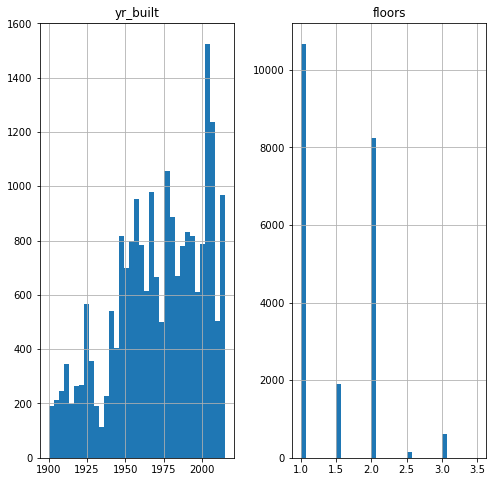

In [282]:
add_numericals.hist(figsize = [8,8], bins='auto');

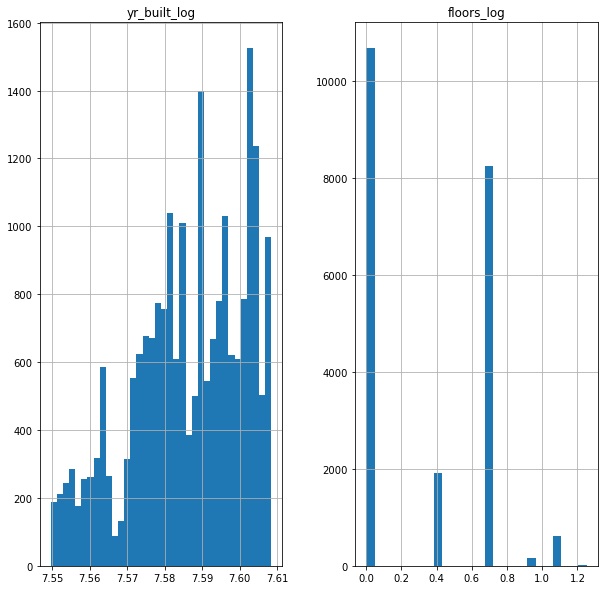

In [343]:
# Perform log transformations for add_numericals 

log_names = [f'{column}_log' for column in add_numericals.columns]

house_log2 = np.log(add_numericals)
house_log2.columns = log_names
house_log.hist(figsize=(10, 10), bins='auto')
fig.tight_layout();

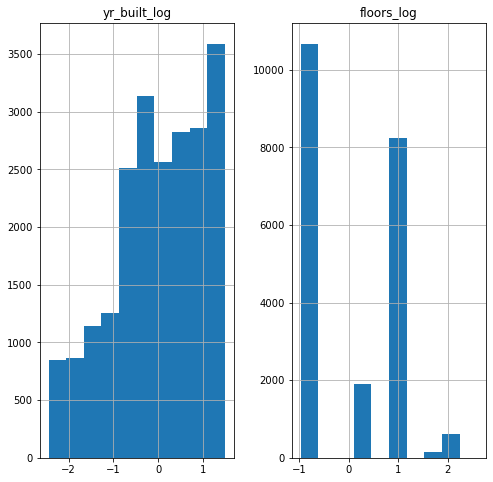

In [344]:
# Standardize the log features

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

features_add = house_log2.apply(normalize)

features_add.hist(figsize  = [8, 8]);

### Additional features not normally distributed.
* Likely to cause skewness.

In [477]:
features_add.describe()

,yr_built_log,floors_log
count,2.159700e+04,2.159700e+04
mean,-2.568837e-15,2.105604e-17
std,1.000000e+00,1.000000e+00
min,-2.445050e+00,-9.608519e-01
25%,-6.743255e-01,-9.608519e-01
50%,1.430005e-01,1.901686e-01
75%,8.835377e-01,1.006831e+00
max,1.483389e+00,2.595449e+00


In [285]:
third_model = pd.concat([second_model, features_add], axis=1)
third_model.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,bd*ba,water_YES,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,...,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,yr_built_log,floors_log
0,-1.125556,-1.726509,-0.279718,-1.401998,0.482936,0,0,0,0,1,...,0,0,0,0,0,1,0,0,-0.537409,-0.960852
1,0.709446,0.339653,-0.279718,0.279938,-0.095007,0,0,0,0,1,...,0,0,0,0,0,1,0,0,-0.674325,1.006831
2,-2.131893,-1.726509,-1.711611,-1.799430,2.955111,0,0,0,0,1,...,0,0,0,0,1,0,0,0,-1.293945,-0.960852
3,0.070674,1.072635,0.736226,0.499698,0.789702,0,0,0,0,1,...,0,0,0,0,0,1,0,0,-0.196338,-0.960852
4,-0.292725,0.039555,-0.279718,0.178434,-0.011064,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0.547946,-0.960852


In [286]:
# Model Summary
X = third_model.drop(['price_log'], axis=1)
y = third_model['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     1743.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:37:38   Log-Likelihood:                -19302.
No. Observations:               21597   AIC:                         3.865e+04
Df Residuals:                   21573   BIC:                         3.884e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1244      0.028     40.779      0.000       1.070       1.178
sqft_living_log         0.3159      0.008     37.430      0.000       0.299       0.332
bathrooms_log           0.1060      0.007     14.539      0.000       0.092       0.120
bedrooms_log           -0.0645      0.006    -11.426      0.000      -0.076      -0.053
bd*ba                   0.0358      0.004      9.493      0.000       0.028       0.043
water_YES               0.6241      0.060     10.406      0.000       0.507       0.742
view_EXCELLENT          0.3296      0.045      7.351      0.000       0.242       0.418
view_FAIR               0.1531      0.038      4.049      0.000       0.079       0.227
view_GOOD               0.0792      0.033      2.431      0.015       0.015       0.143
view_NONE              -0.1931      0.020     -9.640      0.000      -0.232      -0.154
condition_Fair         -0.3113      0.046     -6.746      0.000      -0.402      -0.221
condition_Good          0.0328      0.010      3.265      0.001       0.013       0.052
condition_Very Good     0.1619      0.016     10.000      0.000       0.130       0.194
grade_11 Excellent      0.3798      0.035     10.933      0.000       0.312       0.448
grade_12 Luxury         0.7925      0.066     12.023      0.000       0.663       0.922
grade_13 Mansion        1.3386      0.166      8.063      0.000       1.013       1.664
grade_4 Low            -2.2844      0.119    -19.203      0.000      -2.518      -2.051
grade_5 Fair           -2.1558      0.047    -45.720      0.000      -2.248      -2.063
grade_6 Low Average    -1.7611      0.029    -61.493      0.000      -1.817      -1.705
grade_7 Average        -1.2857      0.023    -56.422      0.000      -1.330      -1.241
grade_8 Good           -0.8515      0.021    -40.772      0.000      -0.892      -0.811
grade_9 Better         -0.3801      0.021    -17.798      0.000      -0.422      -0.338
yr_built_log           -0.3152      0.005    -57.421      0.000      -0.326      -0.304
floors_log              0.0745      0.005     14.580      0.000       0.065       0.085
==============================================================================
Omnibus:                       66.699   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.328
Skew:                          -0.081   Prob(JB):                     1.62e-17
Kurtosis:                       3.245   Cond. No.                         74.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [312]:
X3 = third_model.drop('price_log', axis=1)
y3 = third_model['price_log']

In [313]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X3,y3, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [314]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [315]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [316]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [317]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.3507954634960665
Test Mean Squared Error: 0.3492153432973715


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [318]:
final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test, y_test)

0.6518125761137188

### Third model lowers Variance and Bias
* Adjusted R-squared value increased from 0.587 to .642
* Root Mean Squared Error (RMSE) decreased from 0.404/0.413 (train/test) to 0.351/0.353 (train/test)

# Fourth Model
* Drop predictors with high VIF scores
    * view_NONE
    * grade_7 Average

In [319]:
fourth_model = third_model.drop(['view_NONE', 'grade_7 Average'], axis=1)

fourth_model.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,bd*ba,water_YES,view_EXCELLENT,view_FAIR,view_GOOD,condition_Fair,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_8 Good,grade_9 Better,yr_built_log,floors_log
0,-1.125556,-1.726509,-0.279718,-1.401998,0.482936,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.537409,-0.960852
1,0.709446,0.339653,-0.279718,0.279938,-0.095007,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.674325,1.006831
2,-2.131893,-1.726509,-1.711611,-1.799430,2.955111,0,0,0,0,0,...,0,0,0,0,0,1,0,0,-1.293945,-0.960852
3,0.070674,1.072635,0.736226,0.499698,0.789702,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.196338,-0.960852
4,-0.292725,0.039555,-0.279718,0.178434,-0.011064,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.547946,-0.960852


In [352]:
# Fourth Model Summary
X4 = fourth_model.drop(['price_log'], axis=1)
y4 = fourth_model['price_log']

X_int = sm.add_constant(X4)
model = sm.OLS(y4,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     1515.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        09:06:17   Log-Likelihood:                -20860.
No. Observations:               21597   AIC:                         4.176e+04
Df Residuals:                   21575   BIC:                         4.194e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1596      0.008    -20.705      0.000      -0.175      -0.144
sqft_living_log         0.5188      0.008     62.879      0.000       0.503       0.535
bathrooms_log           0.1080      0.008     13.796      0.000       0.093       0.123
bedrooms_log           -0.1130      0.006    -18.832      0.000      -0.125      -0.101
bd*ba                   0.0585      0.004     14.504      0.000       0.051       0.066
water_YES               0.6040      0.064      9.373      0.000       0.478       0.730
view_EXCELLENT          0.6426      0.044     14.458      0.000       0.556       0.730
view_FAIR               0.3566      0.036     10.033      0.000       0.287       0.426
view_GOOD               0.3538      0.029     12.133      0.000       0.297       0.411
condition_Fair         -0.3228      0.050     -6.509      0.000      -0.420      -0.226
condition_Good          0.0170      0.011      1.580      0.114      -0.004       0.038
condition_Very Good     0.1442      0.017      8.289      0.000       0.110       0.178
grade_11 Excellent      1.0419      0.035     29.568      0.000       0.973       1.111
grade_12 Luxury         1.3297      0.070     18.961      0.000       1.192       1.467
grade_13 Mansion        1.7393      0.178      9.756      0.000       1.390       2.089
grade_4 Low            -0.8485      0.125     -6.793      0.000      -1.093      -0.604
grade_5 Fair           -0.7629      0.043    -17.669      0.000      -0.848      -0.678
grade_6 Low Average    -0.4242      0.017    -24.602      0.000      -0.458      -0.390
grade_8 Good            0.1812      0.011     16.465      0.000       0.160       0.203
grade_9 Better          0.5018      0.016     31.766      0.000       0.471       0.533
yr_built_log           -0.2858      0.006    -49.030      0.000      -0.297      -0.274
floors_log              0.1162      0.005     21.397      0.000       0.106       0.127
==============================================================================
Omnibus:                       33.358   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.998
Skew:                           0.033   Prob(JB):                     3.40e-09
Kurtosis:                       3.198   Cond. No.                         73.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Train, Test, Split 4th Model

In [320]:
X4 = fourth_model.drop('price_log', axis=1)
y4 = fourth_model['price_log']

In [321]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X4,y4, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [322]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [323]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [324]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [325]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.40588535154701244
Test Mean Squared Error: 0.40235216313939637


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [326]:
final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test, y_test)

0.5968430109489297

### Fourth Model reduces fit and increases RMSE.
* The fourth model is not as accurate of a predictor as it decreased the R-squared value and increased the RMSE, or total error, but it reduces multicollinearity and therefore produces  predictions that fit the assumptions of linearity.

# Fifth Model
* Purpose: to provide accurate rather than inferential price change values for predictors.
* Use original numericals with one hot encoded predictors that fit assumptions of linearity.
* Test whether this model fits the assumptions of linearity.

In [511]:
interpret_1 = house_df[['price', 
                     'sqft_living', 
                     'bathrooms',
                     'bedrooms',
                     'yr_built',
                     'floors']]

interpret_2 = pd.concat([interpret_1, 
                         water_dummies, 
                         view_dummies, 
                         condition_dummies,
                         grade_dummies], axis=1)

fifth_model = interpret_2.drop(['view_NONE',
                                'grade_3 Poor',
                                'grade_7 Average',
                                'condition_Poor'], axis=1)

fifth_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                21597 non-null  float64
 1   sqft_living          21597 non-null  int64  
 2   bathrooms            21597 non-null  float64
 3   bedrooms             21597 non-null  int64  
 4   yr_built             21597 non-null  int64  
 5   floors               21597 non-null  float64
 6   water_YES            21597 non-null  uint8  
 7   view_EXCELLENT       21597 non-null  uint8  
 8   view_FAIR            21597 non-null  uint8  
 9   view_GOOD            21597 non-null  uint8  
 10  condition_Fair       21597 non-null  uint8  
 11  condition_Good       21597 non-null  uint8  
 12  condition_Very Good  21597 non-null  uint8  
 13  grade_11 Excellent   21597 non-null  uint8  
 14  grade_12 Luxury      21597 non-null  uint8  
 15  grade_13 Mansion     21597 non-null 

In [512]:
# Model without log or normalization
X5 = fifth_model.drop(['price'], axis=1)
y5 = fifth_model['price']

X_int = sm.add_constant(X5)
model = sm.OLS(y5,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1935.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        13:51:57   Log-Likelihood:            -2.9630e+05
No. Observations:               21597   AIC:                         5.926e+05
Df Residuals:                   21576   BIC:                         5.928e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 6.09e+06   1.33e+05     45.817      0.000    5.83e+06    6.35e+06
sqft_living           211.4594      3.018     70.066      0.000     205.544     217.375
bathrooms            5.557e+04   3512.546     15.821      0.000    4.87e+04    6.25e+04
bedrooms             -4.22e+04   2071.209    -20.374      0.000   -4.63e+04   -3.81e+04
yr_built            -3088.8167     68.299    -45.225      0.000   -3222.687   -2954.946
floors               5.644e+04   3495.164     16.148      0.000    4.96e+04    6.33e+04
water_YES             5.14e+05   2.23e+04     23.072      0.000     4.7e+05    5.58e+05
view_EXCELLENT       2.892e+05   1.54e+04     18.801      0.000    2.59e+05    3.19e+05
view_FAIR            1.261e+05   1.23e+04     10.265      0.000    1.02e+05     1.5e+05
view_GOOD            1.308e+05   1.01e+04     12.947      0.000    1.11e+05    1.51e+05
condition_Fair      -3.817e+04   1.71e+04     -2.226      0.026   -7.18e+04   -4561.612
condition_Good       1.042e+04   3714.662      2.804      0.005    3135.982    1.77e+04
condition_Very Good  4.836e+04   5991.101      8.073      0.000    3.66e+04    6.01e+04
grade_11 Excellent   4.297e+05   1.26e+04     34.137      0.000    4.05e+05    4.54e+05
grade_12 Luxury      8.079e+05   2.49e+04     32.485      0.000    7.59e+05    8.57e+05
grade_13 Mansion     1.866e+06   6.24e+04     29.895      0.000    1.74e+06    1.99e+06
grade_4 Low         -9.048e+04   4.26e+04     -2.124      0.034   -1.74e+05   -6982.078
grade_5 Fair        -1.165e+05   1.46e+04     -7.992      0.000   -1.45e+05   -8.79e+04
grade_6 Low Average -7.276e+04   5728.203    -12.702      0.000    -8.4e+04   -6.15e+04
grade_8 Good         1.326e+04   3765.672      3.521      0.000    5879.082    2.06e+04
grade_9 Better           1e+05   5428.994     18.422      0.000    8.94e+04    1.11e+05
==============================================================================
Omnibus:                    10877.567   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           254020.268
Skew:                           1.914   Prob(JB):                         0.00
Kurtosis:                      19.359   Cond. No.                     2.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Train, Test, Split 5th Model

In [431]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X5,y5, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [432]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [433]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [434]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [435]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 47525346238.90533
Test Mean Squared Error: 49838466732.175545


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [436]:
final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test, y_test)

0.6279092830594378

### Fifth Model ...
* When continued below 

## Investigating Normality

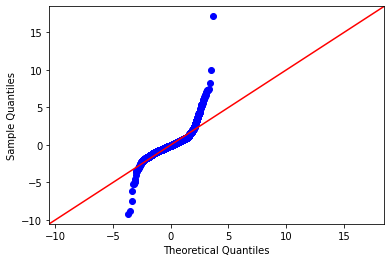

In [437]:
import scipy.stats as stats

preds = final_model.predict(X_test)

residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

### Normality Assumption Met
* Removing the outlier values did not improve the predictive capacity of this model.

## Investigating Multicollinearity (independence assumption)

In [438]:
# estimate multicollinarity with Variance Inflation Factor (VIF)
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

sqft_living            21.272705
bathrooms              25.562027
bedrooms               25.166416
yr_built               27.490527
floors                 13.325009
water_YES               1.498875
view_EXCELLENT          1.545662
view_FAIR               1.026269
view_GOOD               1.063163
condition_Fair          1.028945
condition_Good          1.544861
condition_Very Good     1.159714
grade_11 Excellent      1.314678
grade_12 Luxury         1.148649
grade_13 Mansion        1.044442
grade_4 Low             1.009486
grade_5 Fair            1.047717
grade_6 Low Average     1.343112
grade_8 Good            1.777579
grade_9 Better          1.566431
Name: Variance Inflation Factor, dtype: float64

## Investigating Homoscedasticity

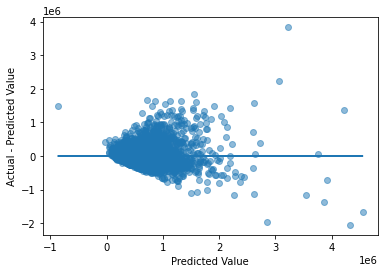

In [439]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

### Homoscedasticity assumption is met
* Removing a few outliers could improve the distribution.

## Linear Regression Assumptions Fifth Model
* Linear Regression Assumptions not met on any category

# Feature Engineering 
* Improve predictive capacity of the model by removing outliers from numerical data.
* Test correlation of Products of Features

## Remove Outliers

In [484]:
remove_outliers = fourth_model

remove_outliers.describe()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,bd*ba,water_YES,view_EXCELLENT,view_FAIR,view_GOOD,condition_Fair,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_8 Good,grade_9 Better,yr_built_log,floors_log
count,2.159700e+04,2.159700e+04,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04,2.159700e+04
mean,-1.518667e-15,-9.475219e-17,-1.026482e-16,1.342323e-15,0.533983,0.006760,0.014678,0.015280,0.023522,0.007871,...,0.018475,0.004121,0.000602,0.001250,0.011205,0.094365,0.280826,0.121082,-2.568837e-15,2.105604e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.198765,0.081944,0.120263,0.122667,0.151557,0.088373,...,0.134664,0.064064,0.024528,0.035337,0.105263,0.292343,0.449413,0.326230,1.000000e+00,1.000000e+00
min,-3.859623e+00,-3.492572e+00,-4.159448e+00,-3.387580e+00,-4.683154,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.445050e+00,-9.608519e-01
25%,-6.725525e-01,-3.006689e-01,-2.797180e-01,-6.949022e-01,-0.095007,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.743255e-01,-9.608519e-01
50%,9.755245e-03,3.396529e-01,-2.797180e-01,-5.926843e-02,0.193964,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.430005e-01,1.901686e-01
75%,6.910288e-01,6.081000e-01,7.362261e-01,6.244262e-01,0.517717,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.835377e-01,1.006831e+00
max,4.626885e+00,3.571681e+00,8.188407e+00,5.333765e+00,14.527172,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.483389e+00,2.595449e+00


In [485]:
remove_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sqft_living_log      21597 non-null  float64
 1   bathrooms_log        21597 non-null  float64
 2   bedrooms_log         21597 non-null  float64
 3   price_log            21597 non-null  float64
 4   bd*ba                21597 non-null  float64
 5   water_YES            21597 non-null  uint8  
 6   view_EXCELLENT       21597 non-null  uint8  
 7   view_FAIR            21597 non-null  uint8  
 8   view_GOOD            21597 non-null  uint8  
 9   condition_Fair       21597 non-null  uint8  
 10  condition_Good       21597 non-null  uint8  
 11  condition_Very Good  21597 non-null  uint8  
 12  grade_11 Excellent   21597 non-null  uint8  
 13  grade_12 Luxury      21597 non-null  uint8  
 14  grade_13 Mansion     21597 non-null  uint8  
 15  grade_4 Low          21597 non-null 

<AxesSubplot:>

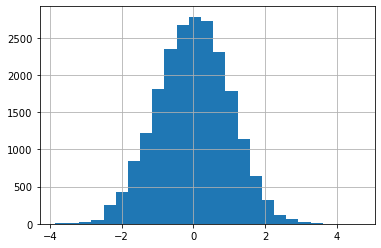

In [486]:
remove_outliers['sqft_living_log'].hist(bins=25)

In [487]:
# find cut-off for data outside 3 standard deviations (99.7% of data)
remove_outliers.quantile(q=.9985)

sqft_living_log        3.025420
bathrooms_log          2.498475
bedrooms_log           2.712499
price_log              3.666191
bd*ba                  8.210544
water_YES              1.000000
view_EXCELLENT         1.000000
view_FAIR              1.000000
view_GOOD              1.000000
condition_Fair         1.000000
condition_Good         1.000000
condition_Very Good    1.000000
grade_11 Excellent     1.000000
grade_12 Luxury        1.000000
grade_13 Mansion       0.000000
grade_4 Low            0.000000
grade_5 Fair           1.000000
grade_6 Low Average    1.000000
grade_8 Good           1.000000
grade_9 Better         1.000000
yr_built_log           1.483389
floors_log             2.157851
Name: 0.9985, dtype: float64

In [488]:
# find cut-off for data outside 3 standard deviations (99.7% of data)
remove_outliers.quantile(q=.0015)

sqft_living_log       -2.882625
bathrooms_log         -2.459491
bedrooms_log          -4.159448
price_log             -2.823059
bd*ba                 -2.631637
water_YES              0.000000
view_EXCELLENT         0.000000
view_FAIR              0.000000
view_GOOD              0.000000
condition_Fair         0.000000
condition_Good         0.000000
condition_Very Good    0.000000
grade_11 Excellent     0.000000
grade_12 Luxury        0.000000
grade_13 Mansion       0.000000
grade_4 Low            0.000000
grade_5 Fair           0.000000
grade_6 Low Average    0.000000
grade_8 Good           0.000000
grade_9 Better         0.000000
yr_built_log          -2.445050
floors_log            -0.960852
Name: 0.0015, dtype: float64

<AxesSubplot:>

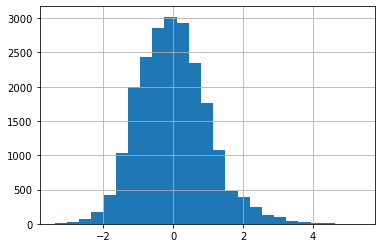

In [489]:
remove_outliers['price_log'].hist(bins=25)

In [490]:
# correlation before removing outliers
remove_outliers.corr()['price_log']['sqft_living_log']

0.674801656673277

In [491]:
remove_outliers = remove_outliers[(remove_outliers['price_log'] > -2.823) & (remove_outliers['price_log'] < 3.666)]

In [492]:
# correlation before removing outliers
remove_outliers.corr()['price_log']['sqft_living_log']

0.666363382048225

In [493]:
remove_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21526 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sqft_living_log      21526 non-null  float64
 1   bathrooms_log        21526 non-null  float64
 2   bedrooms_log         21526 non-null  float64
 3   price_log            21526 non-null  float64
 4   bd*ba                21526 non-null  float64
 5   water_YES            21526 non-null  uint8  
 6   view_EXCELLENT       21526 non-null  uint8  
 7   view_FAIR            21526 non-null  uint8  
 8   view_GOOD            21526 non-null  uint8  
 9   condition_Fair       21526 non-null  uint8  
 10  condition_Good       21526 non-null  uint8  
 11  condition_Very Good  21526 non-null  uint8  
 12  grade_11 Excellent   21526 non-null  uint8  
 13  grade_12 Luxury      21526 non-null  uint8  
 14  grade_13 Mansion     21526 non-null  uint8  
 15  grade_4 Low          21526 non-null 

In [494]:
# Run model summary with only sqft_living_log

# Model Summary
X_ro = remove_outliers.drop(['price_log'], axis=1)
y_ro = remove_outliers['price_log']

X_int = sm.add_constant(X_ro)
model = sm.OLS(y_ro,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     1436.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        13:42:47   Log-Likelihood:                -20665.
No. Observations:               21526   AIC:                         4.137e+04
Df Residuals:                   21504   BIC:                         4.155e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1600      0.008    -20.857      0.000      -0.175      -0.145
sqft_living_log         0.5155      0.008     62.719      0.000       0.499       0.532
bathrooms_log           0.1068      0.008     13.698      0.000       0.092       0.122
bedrooms_log           -0.1130      0.006    -18.893      0.000      -0.125      -0.101
bd*ba                   0.0598      0.004     14.806      0.000       0.052       0.068
water_YES               0.5458      0.067      8.170      0.000       0.415       0.677
view_EXCELLENT          0.6420      0.045     14.344      0.000       0.554       0.730
view_FAIR               0.3480      0.035      9.820      0.000       0.279       0.417
view_GOOD               0.3595      0.029     12.374      0.000       0.303       0.416
condition_Fair         -0.2884      0.050     -5.753      0.000      -0.387      -0.190
condition_Good          0.0147      0.011      1.370      0.171      -0.006       0.036
condition_Very Good     0.1418      0.017      8.193      0.000       0.108       0.176
grade_11 Excellent      1.0246      0.035     28.867      0.000       0.955       1.094
grade_12 Luxury         1.2145      0.075     16.231      0.000       1.068       1.361
grade_13 Mansion        1.4801      0.240      6.168      0.000       1.010       1.950
grade_4 Low            -0.6113      0.134     -4.559      0.000      -0.874      -0.348
grade_5 Fair           -0.6906      0.044    -15.743      0.000      -0.777      -0.605
grade_6 Low Average    -0.4193      0.017    -24.401      0.000      -0.453      -0.386
grade_8 Good            0.1834      0.011     16.763      0.000       0.162       0.205
grade_9 Better          0.5063      0.016     32.220      0.000       0.476       0.537
yr_built_log           -0.2859      0.006    -49.242      0.000      -0.297      -0.275
floors_log              0.1165      0.005     21.554      0.000       0.106       0.127
==============================================================================
Omnibus:                       32.242   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.535
Skew:                           0.045   Prob(JB):                     1.17e-08
Kurtosis:                       3.180   Cond. No.                         98.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## (skip) Remove all rows containing value outside 3 standard deviations
* Chose not to use this method because it dropped ~5% of data
    * This dropped values outside 3 std. dev. in every column.

In [495]:
# remove rows with values in any column outside
# 3 standard deviations.
remove_all_out = fourth_model

z_scores = stats.zscore(remove_all_out)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1, keepdims=True)
new_df = remove_all_out[filtered_entries]

new_df.shape

(16283, 22)

### Considering this removes data, I will use it on the final model to check if it is worth performing to reduce heteroscedasticity and increase normality.
* I may not remove outliers, because it is reducing the predictive capacity of the model.

In [496]:
# did the quantiles change? -Yes
print('Old df:', remove_outliers.quantile(q=.995))
print()
print('New df:', new_df.quantile(q=.995))

Old df: sqft_living_log        2.472881
bathrooms_log          2.105716
bedrooms_log           2.168119
price_log              3.017212
bd*ba                  7.181324
water_YES              1.000000
view_EXCELLENT         1.000000
view_FAIR              1.000000
view_GOOD              1.000000
condition_Fair         1.000000
condition_Good         1.000000
condition_Very Good    1.000000
grade_11 Excellent     1.000000
grade_12 Luxury        0.000000
grade_13 Mansion       0.000000
grade_4 Low            0.000000
grade_5 Fair           1.000000
grade_6 Low Average    1.000000
grade_8 Good           1.000000
grade_9 Better         1.000000
yr_built_log           1.450205
floors_log             2.157851
Name: 0.995, dtype: float64

New df: sqft_living_log        2.030011
bathrooms_log          1.805618
bedrooms_log           2.168119
price_log              2.368580
bd*ba                  2.955111
water_YES              0.000000
view_EXCELLENT         0.000000
view_FAIR              0.00

In [497]:
# correlation after removing outliers.  Correlation decreased.
print('Sqft to Price - R^2 before removing outliers:',remove_outliers.corr()['price_log']['sqft_living_log'])
print('Sqft to Price - R^2 after removing outliers:',new_df.corr()['price_log']['sqft_living_log'])
print()
print('Sqft to Bathrooms - R^2 before removing outliers:',remove_outliers.corr()['price_log']['bathrooms_log'])
print('Sqft to Bathrooms - R^2 after removing outliers:',new_df.corr()['price_log']['bathrooms_log'])
print()
print('Sqft to Bedrooms - R^2 before removing outliers:',remove_outliers.corr()['price_log']['bedrooms_log'])
print('Sqft to Bedrooms - R^2 after removing outliers:',new_df.corr()['price_log']['bedrooms_log'])

Sqft to Price - R^2 before removing outliers: 0.666363382048225
Sqft to Price - R^2 after removing outliers: 0.5746431726012301

Sqft to Bathrooms - R^2 before removing outliers: 0.5113794696381216
Sqft to Bathrooms - R^2 after removing outliers: 0.3800244427698267

Sqft to Bedrooms - R^2 before removing outliers: 0.3353511256201753
Sqft to Bedrooms - R^2 after removing outliers: 0.25259771293911637


### Dropping Outliers reduces correlation values.
* How does it impact normality and heteroscedasticity?

## (skip) Replace Outliers
* Chose to remove rather than replace outliers

In [267]:
replace_out = pd.concat([first_model, features_add], axis=1)

replace_out.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,bd*ba,yr_built_log,floors_log
0,-1.125556,-1.726509,-0.279718,-1.401998,0.482936,-0.537409,-0.960852
1,0.709446,0.339653,-0.279718,0.279938,-0.095007,-0.674325,1.006831
2,-2.131893,-1.726509,-1.711611,-1.799430,2.955111,-1.293945,-0.960852
3,0.070674,1.072635,0.736226,0.499698,0.789702,-0.196338,-0.960852
4,-0.292725,0.039555,-0.279718,0.178434,-0.011064,0.547946,-0.960852


In [268]:
# find cut-off for data outside 3 standard deviations (99.7% of data)
print('lower quantile:',replace_out.quantile(q=.0015))
print()
print('upper quantile:',replace_out.quantile(q=.9985))


lower quantile: sqft_living_log   -2.882625
bathrooms_log     -2.459491
bedrooms_log      -4.159448
price_log         -2.823059
bd*ba             -2.631637
yr_built_log      -2.445050
floors_log        -0.960852
Name: 0.0015, dtype: float64

upper quantile: sqft_living_log    3.025420
bathrooms_log      2.498475
bedrooms_log       2.712499
price_log          3.666191
bd*ba              8.210544
yr_built_log       1.483389
floors_log         2.157851
Name: 0.9985, dtype: float64


In [269]:
# https://stackoverflow.com/questions/45386955/python-replacing-outliers-values-with-median-values
# http://localhost:8888/notebooks/t20/ds-feature_selection_and_feature_engineering-nbz32/feature_selection_and_feature_engineering.ipynb

median = replace_out['sqft_living_log'].median()

# replace lower threshold of sqft_living_log
replace_out["sqft_living_log"] = np.where(
    replace_out["sqft_living_log"] > -2.883, median,replace_out['sqft_living_log'])

# replace upper threshold of sqft_living_log
replace_out["sqft_living_log"] = np.where(
    replace_out["sqft_living_log"] < 3.025, median,replace_out['sqft_living_log'])


In [270]:
# find cut-off for data outside 3 standard deviations (99.7% of data)

print('lower quantile:',replace_out.quantile(q=.0015))
print()
print('upper quantile:',replace_out.quantile(q=.9985))


lower quantile: sqft_living_log    0.009755
bathrooms_log     -2.459491
bedrooms_log      -4.159448
price_log         -2.823059
bd*ba             -2.631637
yr_built_log      -2.445050
floors_log        -0.960852
Name: 0.0015, dtype: float64

upper quantile: sqft_living_log    0.009755
bathrooms_log      2.498475
bedrooms_log       2.712499
price_log          3.666191
bd*ba              8.210544
yr_built_log       1.483389
floors_log         2.157851
Name: 0.9985, dtype: float64


In [271]:
# correlation after replacing outliers with mean
replace_out.corr()['price_log']['sqft_living_log']

-8.096569752015661e-17

## Product features
* Experimenting with 
* What would correlation be for product of bedrooms and bathrooms with price?

In [472]:
# product of bedrooms and bathrooms
product_features = remove_outliers

product_features['bd*ba'
                ] = remove_outliers['bedrooms_log'
                ] * remove_outliers['bathrooms_log']


<ipython-input-472-9237b1b96362>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_features['bd*ba'


In [473]:
# R-squared for product of bedrooms and bathrooms with price
product_featuers.corr()['price_log']['bd*ba']

-0.009202932148371685

In [474]:
# R-squared for bedrooms and price
product_featuers.corr()['price_log']['bedrooms_log']

0.3353511256201753

In [475]:
# R-squared for bathrooms and price
product_featuers.corr()['price_log']['bathrooms_log']

0.5113794696381216

### Product of bedrooms and bathrooms reduces correlation.
* Correlation between bedrooms and bathrooms reduced when using product of bed*bath.

# Interpret the Final Model
* The Fourth Model after price outliers were dropped is the final model as it met the assumptions for linearity and it provides relevant inferential information, if not an actual change in price.

In [498]:
X_r = remove_outliers.drop('price_log', axis=1)
y_r = remove_outliers['price_log']

In [499]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X_r,y_r, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12915 8611 12915 8611


In [500]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [501]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [502]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [503]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.3998334472036865
Test Mean Squared Error: 0.39958032599230514


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [504]:
final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test, y_test)

0.5887382431879064

## Investigating Normality

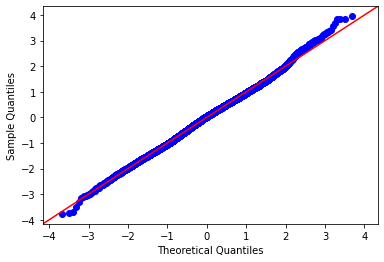

In [505]:
import scipy.stats as stats

preds = final_model.predict(X_test)

residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

### Normality Assumption Met
* Removing the outlier values did not greatly improve the normality of this model.

## Investigating Multicollinearity (independence assumption)

In [506]:
# estimate multicollinarity with Variance Inflation Factor (VIF)
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

sqft_living_log        3.458024
bathrooms_log          3.187775
bedrooms_log           1.886579
bd*ba                  1.391270
water_YES              1.418365
view_EXCELLENT         1.456809
view_FAIR              1.030192
view_GOOD              1.066507
condition_Fair         1.025096
condition_Good         1.325383
condition_Very Good    1.167699
grade_11 Excellent     1.159871
grade_12 Luxury        1.062463
grade_13 Mansion       1.009978
grade_4 Low            1.029557
grade_5 Fair           1.114107
grade_6 Low Average    1.419088
grade_8 Good           1.288857
grade_9 Better         1.333960
yr_built_log           1.760603
floors_log             1.563500
Name: Variance Inflation Factor, dtype: float64

### Removed predictors with score greater than 5
* view_NONE (12.4)
* grade_7 Average (7.42)

## Investigating Homoscedasticity

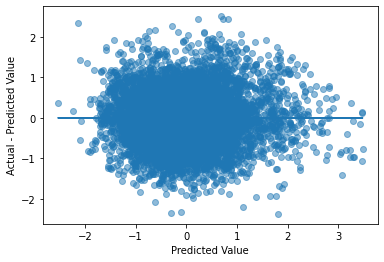

In [507]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

### Homoscedasticity assumption is met
* Removing a few outliers did slightly improve the distribution.
    * Improvement in terms of trimming the predicted values to be in a similar range about 0.
   

# Interpretting Coefficients


## Fourth and Final Model

In [353]:
# Comparing to Fourth Model Summary
X4 = fourth_model.drop(['price_log'], axis=1)
y4 = fourth_model['price_log']

X_int = sm.add_constant(X4)
model = sm.OLS(y4,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     1515.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        09:06:45   Log-Likelihood:                -20860.
No. Observations:               21597   AIC:                         4.176e+04
Df Residuals:                   21575   BIC:                         4.194e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1596      0.008    -20.705      0.000      -0.175      -0.144
sqft_living_log         0.5188      0.008     62.879      0.000       0.503       0.535
bathrooms_log           0.1080      0.008     13.796      0.000       0.093       0.123
bedrooms_log           -0.1130      0.006    -18.832      0.000      -0.125      -0.101
bd*ba                   0.0585      0.004     14.504      0.000       0.051       0.066
water_YES               0.6040      0.064      9.373      0.000       0.478       0.730
view_EXCELLENT          0.6426      0.044     14.458      0.000       0.556       0.730
view_FAIR               0.3566      0.036     10.033      0.000       0.287       0.426
view_GOOD               0.3538      0.029     12.133      0.000       0.297       0.411
condition_Fair         -0.3228      0.050     -6.509      0.000      -0.420      -0.226
condition_Good          0.0170      0.011      1.580      0.114      -0.004       0.038
condition_Very Good     0.1442      0.017      8.289      0.000       0.110       0.178
grade_11 Excellent      1.0419      0.035     29.568      0.000       0.973       1.111
grade_12 Luxury         1.3297      0.070     18.961      0.000       1.192       1.467
grade_13 Mansion        1.7393      0.178      9.756      0.000       1.390       2.089
grade_4 Low            -0.8485      0.125     -6.793      0.000      -1.093      -0.604
grade_5 Fair           -0.7629      0.043    -17.669      0.000      -0.848      -0.678
grade_6 Low Average    -0.4242      0.017    -24.602      0.000      -0.458      -0.390
grade_8 Good            0.1812      0.011     16.465      0.000       0.160       0.203
grade_9 Better          0.5018      0.016     31.766      0.000       0.471       0.533
yr_built_log           -0.2858      0.006    -49.030      0.000      -0.297      -0.274
floors_log              0.1162      0.005     21.397      0.000       0.106       0.127
==============================================================================
Omnibus:                       33.358   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.998
Skew:                           0.033   Prob(JB):                     3.40e-09
Kurtosis:                       3.198   Cond. No.                         73.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Fifth and non-normal NOT final Model
* Provides values that can be used to predict price, but not compared well to one another.

In [515]:
# Comparing to Fourth Model Summary
X5 = fifth_model.drop(['price'], axis=1)
y5 = fifth_model['price']

X_int = sm.add_constant(X5)
model = sm.OLS(y5,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1935.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        13:52:57   Log-Likelihood:            -2.9630e+05
No. Observations:               21597   AIC:                         5.926e+05
Df Residuals:                   21576   BIC:                         5.928e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 6.09e+06   1.33e+05     45.817      0.000    5.83e+06    6.35e+06
sqft_living           211.4594      3.018     70.066      0.000     205.544     217.375
bathrooms            5.557e+04   3512.546     15.821      0.000    4.87e+04    6.25e+04
bedrooms             -4.22e+04   2071.209    -20.374      0.000   -4.63e+04   -3.81e+04
yr_built            -3088.8167     68.299    -45.225      0.000   -3222.687   -2954.946
floors               5.644e+04   3495.164     16.148      0.000    4.96e+04    6.33e+04
water_YES             5.14e+05   2.23e+04     23.072      0.000     4.7e+05    5.58e+05
view_EXCELLENT       2.892e+05   1.54e+04     18.801      0.000    2.59e+05    3.19e+05
view_FAIR            1.261e+05   1.23e+04     10.265      0.000    1.02e+05     1.5e+05
view_GOOD            1.308e+05   1.01e+04     12.947      0.000    1.11e+05    1.51e+05
condition_Fair      -3.817e+04   1.71e+04     -2.226      0.026   -7.18e+04   -4561.612
condition_Good       1.042e+04   3714.662      2.804      0.005    3135.982    1.77e+04
condition_Very Good  4.836e+04   5991.101      8.073      0.000    3.66e+04    6.01e+04
grade_11 Excellent   4.297e+05   1.26e+04     34.137      0.000    4.05e+05    4.54e+05
grade_12 Luxury      8.079e+05   2.49e+04     32.485      0.000    7.59e+05    8.57e+05
grade_13 Mansion     1.866e+06   6.24e+04     29.895      0.000    1.74e+06    1.99e+06
grade_4 Low         -9.048e+04   4.26e+04     -2.124      0.034   -1.74e+05   -6982.078
grade_5 Fair        -1.165e+05   1.46e+04     -7.992      0.000   -1.45e+05   -8.79e+04
grade_6 Low Average -7.276e+04   5728.203    -12.702      0.000    -8.4e+04   -6.15e+04
grade_8 Good         1.326e+04   3765.672      3.521      0.000    5879.082    2.06e+04
grade_9 Better           1e+05   5428.994     18.422      0.000    8.94e+04    1.11e+05
==============================================================================
Omnibus:                    10877.567   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           254020.268
Skew:                           1.914   Prob(JB):                         0.00
Kurtosis:                      19.359   Cond. No.                     2.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Dollar value changes for predictors in Fifth model.
* For every increase in 1 square foot, the price increases by 211.46 dollars
    * This is an increase of 105,730.00 dollars for every 500 square feet.
* For every additional bedroom, the price decreases by 42,200 dollars.
    * This is an issue in our model because homes with fewer bedrooms are likely to cost more than homes with more bedrooms - likely conflated by other variables such as location.
* For each additional bathroom, the price of a home increses by 55,570 dollars.
* For every year a house becomes older, it decreases in value by 3,088.82 dollars.
* Each additional floor increases the value of a home by 56,440.00
* Improving the view from Fair to Excellent will increase the value of a home by 163,100 dollars.
    * Improving view from Fair to Good will increase the value of a home by only 4700 dollars.
* Improving the grade of a house from Fair to Excellent, which would require significant renovations and additions, improves the value of a house by 546,200 dollars.
    * Improving the grade of a house from Low to Fair will only increase the value by 26,020 dollars.

## Un-Normalize Coefficients

In [381]:
# form data frame with coefficients

lr = LinearRegression()
lr.fit(X4,y4)

orig_coefs = lr.coef_

coefs1 = pd.DataFrame(
    data={
        'feature': fourth_model.drop(['price_log'], axis=1).columns, 
        'orig_coef' : orig_coefs, 
    }
)
coefs1

,feature,orig_coef
0,sqft_living_log,0.518826
1,bathrooms_log,0.108043
2,bedrooms_log,-0.112985
3,bd*ba,0.058490
4,water_YES,0.603956
5,view_EXCELLENT,0.642621
6,view_FAIR,0.356569
7,view_GOOD,0.353794
8,condition_Fair,-0.322837
9,condition_Good,0.017032


In [388]:
# finding coefficient in this data frame
coefs1.iloc[0]['orig_coef']

0.518825567109816

In [387]:
# find and re-name logged data frames

print(house_log.info())
print(house_log2.info())

house_log3 = pd.concat([house_log, house_log2], axis=1)
print(house_log3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft_living_log  21597 non-null  float64
 1   bathrooms_log    21597 non-null  float64
 2   bedrooms_log     21597 non-null  float64
 3   price_log        21597 non-null  float64
dtypes: float64(4)
memory usage: 675.0 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr_built_log  21597 non-null  float64
 1   floors_log    21597 non-null  float64
dtypes: float64(2)
memory usage: 337.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft_living_log  21597 non-null  floa

### Comparing coefficients in house_log3 to calculated values
* They do not compare well - I am not sure why the values are so different

In [395]:
# Model summary of house_log3
X_log = house_log3.drop(['price_log'], axis=1)
y_log = house_log3['price_log']

X_int = sm.add_constant(X_log)
model = sm.OLS(y_log,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     4766.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:38:01   Log-Likelihood:                -8761.6
No. Observations:               21597   AIC:                         1.754e+04
Df Residuals:                   21591   BIC:                         1.758e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              81.0346      1.557     52.059      0.000      77.984      84.086
sqft_living_log     0.9011      0.010     89.795      0.000       0.881       0.921
bathrooms_log       0.1935      0.011     17.325      0.000       0.172       0.215
bedrooms_log       -0.3324      0.012    -28.712      0.000      -0.355      -0.310
yr_built_log       -9.8333      0.205    -48.050      0.000     -10.234      -9.432
floors_log          0.1996      0.009     23.444      0.000       0.183       0.216
==============================================================================
Omnibus:                        8.847   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.325
Skew:                           0.023   Prob(JB):                      0.00944
Kurtosis:                       3.090   Cond. No.                     6.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Set up equation 

In [405]:
# convert normalized value to logged value for logged and normalized 
# coefficient of sqft_living

un_normalized_sqft_living_coeff = (((coefs1.iloc[0]['orig_coef']) 
                        * house_log3['sqft_living_log'].std())
                        + house_log3['sqft_living_log'].mean())

# print result
print("Un-normalized coefficient of sqft_living:", 
      un_normalized_sqft_living_coeff)
print()

# invert natural log
orig_coeff_sqft_living = np.exp(log_sqft_living_coeff)

# print result
print("Calculated, un-normalized, log inverted, coeff of sqft_living:", 
      orig_coeff_sqft_living)

Un-normalized coefficient of sqft_living: 7.770801574952525

Calculated, un-normalized, log inverted, coeff of sqft_living: 2370.370556717152


### Calculated Value of Un-normalized, Log-inverted, Coefficient of sqft_living
* The calculated value of 2370.37 does not seem realistic to me.
    * An increase of that magnitude would mean houses rise in value by 1,185,000.00 dollars for every additional 500 square feet.

In [399]:
# double-check values of sqft_living_log in house_log3
print(house_log3['sqft_living_log'].std())
print(house_log3['sqft_living_log'].mean())

0.42419100991702274
7.55072043366944


<AxesSubplot:>

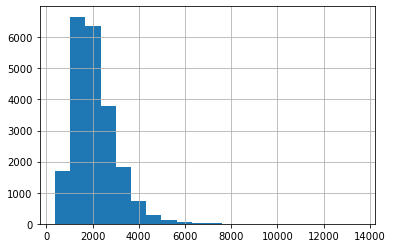

In [400]:
house_df['sqft_living'].hist(bins=20)

### Converting logged and normalized coefficients to original value, does not provide a coefficient for the original data set.
* They provide a value that is near the mean of the data, not a coefficient.
    * The value is near the mean because the conversion from the normalized value to the logged value results in a value near the mean, as the normalized values center upon the mean.
* We would need to convert all of the values in the normalized data frame to logged, then find the inverse of the log, then run a summary.
    * At this point, we would be running a summary of the original data.

# Recommendations

## Renovate Interior
* Grade and Condition score increases were correlated to large price increases.
* Spending on an interior renovation, especially in regards to the whole house being considered very good to luxury is likely to increase sale price.

## Create a View
* Add larger windows that face pleasant scenery.
* Add a deck or rooftop deck to enhance access to outdoor views.
* Landscape and design views from windows to include desirable plants and scenery.

## Add Square Footage
* Add liveable space in your home.
* Not necessarily bedrooms or bathrooms, though it is better to add bathrooms, in terms of sale price.
* Renovate Garage to be fully insulated livable space.
* Add a guest cottage with full pluming, electrical, and HVAC.


# Future Work

## Examine other housing data sets to determine if they contain similar trends to predictors in the King County Data Set.

## Find additional predictors to better estimate how much certain home changes alter sale price. 
* Type of remodel or home additions.
    * Ex. Kitchen, Garage, Patio, additional Bedrooms/Bathrooms.

## Estimate return on investment for renovations.
* How do certain projects increase sale price?
    * Example: Is it better to convert a garage to livable space or update a bathroom?
* Is it better to spend more to make more, or is there a certain level of spending that reaps a higher gain?

In [337]:
"""
I am very curious about making the label encoder 
work with numbers that I determine.

I wonder if the label encoder will produce different results
than the one hot encoder in terms of the R-squared
and variance?
"""

'\nI am very curious about making the label encoder \nwork with numbers that I determine.\n\nI wonder if the label encoder will produce different results\nthan the one hot encoder in terms of the R-squared\nand variance.\n'

In [ ]:
# This is where I left off 2/21 - need to do ohe for grade
# need to remove 1 column for each ohe variable due to 
# multicollinearity
# next add these to baseline model
# move into train, test, split for model to check how well
# it performs.

# not too many other categories to add, but could do some
# engineering/modification of numerical columns to adjust
# for outliers

# then establish recommendations for renovations.

In [106]:
view_df.value_counts(dropna=False)

NameError: name 'view_df' is not defined

In [ ]:
# failing to drop nan values from categoricals['view']
# categoricals.dropna(subset=['view'], inplace=True)

In [ ]:
# Trying to use default dict to replace values 

# import collections
# d = collections.defaultdict(lambda:0)
# d["NONE"] = 0
# d["AVERAGE"] = 1
# d["GOOD"] = 2
# d["FAIR"] = 3
# d["EXCELLENT"] = 4

# print(d["NONE"])

In [ ]:
view_df.replace(to_replace ="NONE", 

view_df.replace(to_replace =["NONE"], value ="0")

In [ ]:
view_df = categoricals['view'].astype('str')

view_df.replace({"NONE": "0", 
                            "AVERAGE": 1,
                            "GOOD": 2, 
                            "FAIR": 3, 
                            "EXCELLENT": 4})

view_df.value_counts(dropna=False)

In [ ]:
cat_new.head()

In [ ]:
cat_new.to_frame()

In [ ]:
categoricals.info()

In [ ]:
d_frames = [cat_new, categoricals]

# all_cats = pd.concat(d_frames, axis=0, join='outer')
categoricals.join(cat_new, lsuffix='grade', rsuffix='view')

all_cats.head()

In [ ]:
all_cats.shape

In [ ]:
categoricals.head()

In [ ]:
le = LabelEncoder()

cat_view = categoricals['view'].astype('str')

le.fit(cat_view)
le.transform(cat_view)


In [ ]:
# Remove nan values from cat_view
cat_view.dropna()
cat_view.value_counts()

In [ ]:
# Encode view categories to numericals
view_encoded = lb_make.fit_transform(cat_view)

view_encoded

In [ ]:
cat_view.value_counts()

In [ ]:
view_df = pd.DataFrame(view_encoded)
view_df.value_counts()